In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import argparse
from sklearn.utils import shuffle
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.models import load_model
import pandas as pd
from time import time
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import os
import matplotlib.image as mpimg
import cv2
pi = math.pi
%matplotlib inline

Using TensorFlow backend.


In [3]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def matlab_style_log2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h1 = h*(x*x + y*y - 2.*sigma*sigma)/(sigma*sigma**2)
    h = h1 - sum(h1)/(shape[0]*shape[1])  
    return h

In [4]:
def makefilter(scale,phasex,phasey,pts,sup):
    gx=gauss1d(3*scale,0,pts[0,:],phasex);
    gy=gauss1d(scale,0,pts[1,:],phasey);
    f=normalise(np.reshape(gx*gy,(sup-1,sup-1)));
    return f

In [5]:
def gauss1d(sigma,mean,x,ord):
  x=x-mean
  num=x*x
  variance=sigma**2
  denom=2*variance
  g=np.exp(-num/denom)/np.sqrt(pi*denom)
  if (ord ==1):
    g=-g*(x/variance)
  elif (ord == 2):
    g=g*((num-variance)/(variance^2));
  return g

In [6]:
def normalise(f):
    f = f-np.mean(f)
    f = f/np.sum(np.abs(f))
    return f

In [7]:
sup = 12
scalex = np.array([1,2])
norient =4
nrotinv = 2
nbar=len(scalex)*norient
nedge=len(scalex)*norient
nf=nbar+nedge+nrotinv
f = np.zeros([sup-1,sup-1,nf])
hsup = (sup-1)/2;

In [8]:
xin = np.arange(-hsup, hsup, 1)
yin = np.arange(hsup,-hsup,-1)
x,y = np.meshgrid(xin,yin)
orgpts=np.array([x, y])
orgpts = np.reshape(orgpts,(2,(sup-1)**2))  

In [9]:
count=0
for scale  in range( len(scalex)):
    for orient in range(norient):
        angle=math.pi*orient/norient;  #Not 2pi as filters have symmetry
        c=math.cos(angle)
        s=math.sin(angle)      
        rotpts=np.matmul(np.array([[c, -s],[s, c]]),orgpts)
        f[:,:,count]=makefilter(scalex[scale],0,1,rotpts,sup)
        f[:,:,count+nedge]=makefilter(scalex[scale],0,2,rotpts,sup)
        count = count+1     

In [10]:
f[:,:,nbar+nedge]=normalise(matlab_style_gauss2D((sup-1,sup-1),10))
f[:,:,nbar+nedge+1]=normalise(matlab_style_log2D((sup-1,sup-1),10))

In [12]:
fh = open("tiny-imagenet-200/wnids.txt")
count = 0
yval = []
for line in fh:
    nl = ''
    for e in line:
        if e == '\n':
            break
        else:
            nl = nl+e
    yval.append(nl)
    #print(line)
    count+=1
fh.close()
print(count)

os.chdir('tiny-imagenet-200/train')
t2 = os.listdir()
cwd = os.getcwd()

class_size = 200
size = 500*class_size

x = []
y = np.zeros([size,class_size])
c = 0
c2 = 0
for d in t2: 
    for f2 in os.listdir(d+'/images'):
        x.append(cwd+'\\'+d+'\\images\\'+f2)
        y[c,c2] = 1
        c = c+1        
    c2+=1    


200


In [13]:
os.chdir('..')
os.chdir('..')

fh = open("tiny-imagenet-200/val/val_annotations.txt")
count = 0
yval = []
yspot = []
for line in fh:
    nl = ''
    nl2 = ''
    for e in line:
        if (e == '\t'):
            count +=1
        elif (count ==0):
            nl2 = nl2 +e
        elif (count == 1): 
            nl = nl+e
        elif count > 1: 
            break
    yval.append(nl)
    yspot.append(nl2)
    #print(line)
    count = 0
fh.close()

os.chdir('tiny-imagenet-200/train')
t3 = os.listdir()

os.chdir('..')
os.chdir('..')

os.chdir('tiny-imagenet-200/val/images')
t2 = os.listdir()
cwd = os.getcwd()

class_size = 200
sizev = 10000

xv = []
yv = np.zeros([sizev,class_size])
c = 0
c2 = 0
for d in yspot:
    xv.append(cwd+'\\'+d)
    yv[c, t3.index(yval[c])] = 1
    c = c+1

In [14]:
import random

def preprocess(img):
    img_out= img.astype('float32')
    img_out=img_out/255
    return img_out

def generator(x, y, batch_size=128):
    num_samples = len(x)
    x, y = shuffle(x, y)
    while True:
        images = []
        angles = []        
        for offset in range(0, num_samples, batch_size):
            images = []
            batch_y = y[offset:offset + batch_size]
            batch_x = x[offset:offset + batch_size]            
            for z in batch_x:
                images.append(cv2.imread(z))
            for h in batch_y:
                angles.append(h)
            X_train = np.array(images)
            y_train = np.array(batch_y)
            X_train = preprocess(X_train)            
            yield X_train, y_train
 
            
def generator_filter(x, y, batch_size=128):
    num_samples = len(x)
    x, y = shuffle(x, y)
    while True:
        images = []
        angles = []
        figures = np.empty([64,64,54], dtype='float32')      
        for offset in range(0, num_samples, batch_size):
            images = []
            figures = np.empty([64,64,54], dtype='float32')
            batch_y = y[offset:offset + batch_size]
            batch_x = x[offset:offset + batch_size]         
            for z in batch_x:             
                imag=preprocess(cv2.imread(z))
                figures = np.empty([64,64,54], dtype='float32')
                for i in range(18):
                    figures[:,:,i*3:i*3+3] =  cv2.filter2D(imag,-1,f[:,:,i])
                images.append(figures)
            for h in batch_y:
                angles.append(h)
            X_train = np.array(images)
            y_train = np.array(batch_y)
            yield X_train, y_train

train_generator = generator(x,y)
val_generator = generator(xv,yv)
filter_generator = generator_filter(x,y)
val_filter_generator = generator_filter(xv,yv)

In [15]:
model = Sequential()
model.add(layers.Conv2D(filters=54, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(64,64,3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.50))
model.add(layers.Dense(units=4096, activation='relu'))
model.add(layers.Dense(units=2048, activation='relu'))
model.add(layers.Dense(units=class_size, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 54)        1512      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 54)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       172928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
__________

In [19]:
filter_model = Sequential()
filter_model.add(layers.MaxPooling2D(input_shape=(64,64,54)))
filter_model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
filter_model.add(layers.MaxPooling2D())
filter_model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
filter_model.add(layers.MaxPooling2D())
filter_model.add(layers.Flatten())
filter_model.add(layers.Dropout(0.50))
filter_model.add(layers.Dense(units=4096, activation='relu'))
filter_model.add(layers.Dense(units=2048, activation='relu'))
filter_model.add(layers.Dense(units=class_size, activation = 'softmax'))
filter_model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 54)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       172928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12544)             0         
__________

In [20]:
filter_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
fm = filter_model.fit_generator(filter_generator, steps_per_epoch=size/128,epochs=15, 
                                validation_data = val_filter_generator, validation_steps = 10000/128)

Epoch 1/15
782/781 [==============================] - 517s 661ms/step - loss: 4.7002 - acc: 0.0545 - val_loss: 4.0760 - val_acc: 0.1184
Epoch 2/15
782/781 [==============================] - 502s 642ms/step - loss: 3.8364 - acc: 0.1563 - val_loss: 3.6096 - val_acc: 0.2024
Epoch 3/15
782/781 [==============================] - 503s 643ms/step - loss: 3.4230 - acc: 0.2263 - val_loss: 3.4600 - val_acc: 0.2309
Epoch 4/15
782/781 [==============================] - 503s 643ms/step - loss: 3.0672 - acc: 0.2886 - val_loss: 3.4005 - val_acc: 0.2480
Epoch 5/15
782/781 [==============================] - 504s 644ms/step - loss: 2.7210 - acc: 0.3513 - val_loss: 3.4775 - val_acc: 0.2515
Epoch 6/15
782/781 [==============================] - 489s 625ms/step - loss: 2.3713 - acc: 0.4171 - val_loss: 3.6440 - val_acc: 0.2528
Epoch 7/15
782/781 [==============================] - 475s 607ms/step - loss: 2.0459 - acc: 0.4854 - val_loss: 4.0370 - val_acc: 0.2351
Epoch 8/15
782/781 [============================

In [22]:
os.chdir('..')
os.chdir('..')
os.chdir('..')

#serialize model to JSON
model_json = filter_model.to_json()
with open("filter_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
filter_model.save_weights("filter_model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
m = model.fit_generator(train_generator, steps_per_epoch=size/128,epochs=15
                        ,validation_data = val_generator, validation_steps = 10000/128)

Epoch 1/15
782/781 [==============================] - 132s 168ms/step - loss: 5.0926 - acc: 0.0190 - val_loss: 4.6300 - val_acc: 0.0544
Epoch 2/15
782/781 [==============================] - 124s 159ms/step - loss: 4.2274 - acc: 0.1055 - val_loss: 3.9338 - val_acc: 0.1414
Epoch 3/15
782/781 [==============================] - 125s 160ms/step - loss: 3.7139 - acc: 0.1810 - val_loss: 3.7073 - val_acc: 0.1832
Epoch 4/15
782/781 [==============================] - 125s 160ms/step - loss: 3.3946 - acc: 0.2313 - val_loss: 3.5330 - val_acc: 0.2184
Epoch 5/15
782/781 [==============================] - 125s 159ms/step - loss: 3.1432 - acc: 0.2730 - val_loss: 3.5191 - val_acc: 0.2252
Epoch 6/15
782/781 [==============================] - 125s 159ms/step - loss: 2.8872 - acc: 0.3174 - val_loss: 3.5311 - val_acc: 0.2318
Epoch 7/15
782/781 [==============================] - 125s 159ms/step - loss: 2.6441 - acc: 0.3633 - val_loss: 3.6089 - val_acc: 0.2359
Epoch 8/15
782/781 [============================

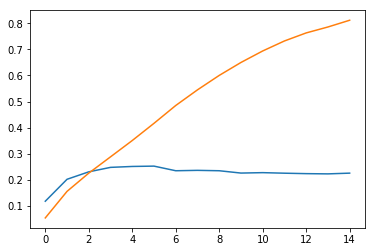

In [21]:
plt.plot(fm.history['val_acc'])
plt.plot(fm.history['acc'])

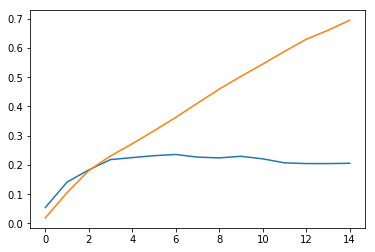

In [17]:

plt.plot(m.history['val_acc'])
plt.plot(m.history['acc'])

In [18]:
 #serialize model to JSON
os.chdir('..')
os.chdir('..')
os.chdir('..')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
